# Capstone - Tree Classification By Bark

## ***This Is The BrainStation capstone project* For tree classification by bark use cases include but not limited to;*

* **Tree detection from a distance to predict landscape patters.**
* **Tree detection to minimize forest fire damage among a forested area.**
* **tree classification to optimize seasonal harvesting within various tree species**

## What is this about?

This project is about classifying what type of tree species a tree belongs to solely based off of an image of its bark, in specific, we'll start with classifying a various amount of trees to be exact 50 types of different trees each of which have a different type of bark with over a hundred pictures to each type of tree bark. The goal is construct a model that has an above 70% accuracy with both training and validation sets, and the difference between the validation set is less than 5%, because we don't want our model to over fit.

# Table Of Contents

###  [First Model](#model1)
### [Second Model](#model2)
### [Third Model](#model3)

## Plan Of Action
 - EDA & Data visualization
 - Split the data into training and validation set
 - Make a manual model
 - Import transfer learning models
 - Use insights from our model to buff transfer learning models
 - Pick the best Model
 - Conclude our findings

In [2]:
from matplotlib.image import imread
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
import os
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import experimental
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import ResNet50V2, VGG19, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from tensorflow import keras
import math
import matplotlib.image as mpimg
import requests
from io import BytesIO

let's get our data in order and see map all the images to their respective directory so that we know where all the images reside and which images belong to which class so that there is no confusion later. That is quite percisely what  the code below is doing.

In [3]:
dir_to_pic = {}
image_data = []
files = glob.glob("BarkVN-50/BarkVN-50_mendeley/*")
for pic_dir in files:
    for image in glob.glob(f"{pic_dir}/*"):
        image_conv = Image.open(image).convert("L")
        arr = np.asarray(image_conv)
        image_data.append(arr)
        dir_to_pic.setdefault(pic_dir.split("/")[-1], []).append(arr)

Now let's make an image viewer function that we can use to look at random grey scale samples of images from our data set, note how the function automatically makes it's own grid and scales it based off of how many images the user of it desires to see.

In [4]:
# Made a little helper to view images just to be able to inspect the better
def bulk_image_viewer(amount=10):
    # A helper function to determine factors
    def factors(n):
        lst = []
        for i in range(1, int(n**(1 / 2)+1)):
                if n % i == 0:
                     lst.append((i, int(n / i)))
        return lst
    # Get factors for the dimensions
    dims=factors(amount)[-1]
    # Set the figure and axes dimensions and figsize
    fig, axes = plt.subplots(dims[0], dims[1], figsize=(16,16))
    # Plots the plots recursive based on the amount requested
    for i in range(amount):
        plt.subplot(dims[0], dims[1], i+1)
        # Plot a random image in gray scale
        plt.imshow(image_data[random.randint(0, len(image_data)-1)], cmap='gray');

Below we map the amount of images in each directory to the directory so we can get a better feel for the class balance of images or the lack there of.

In [5]:
dir_to_img = {}
for i in dir_to_pic:
    dir_to_img[i] =  len(dir_to_pic[i])

<AxesSubplot:>

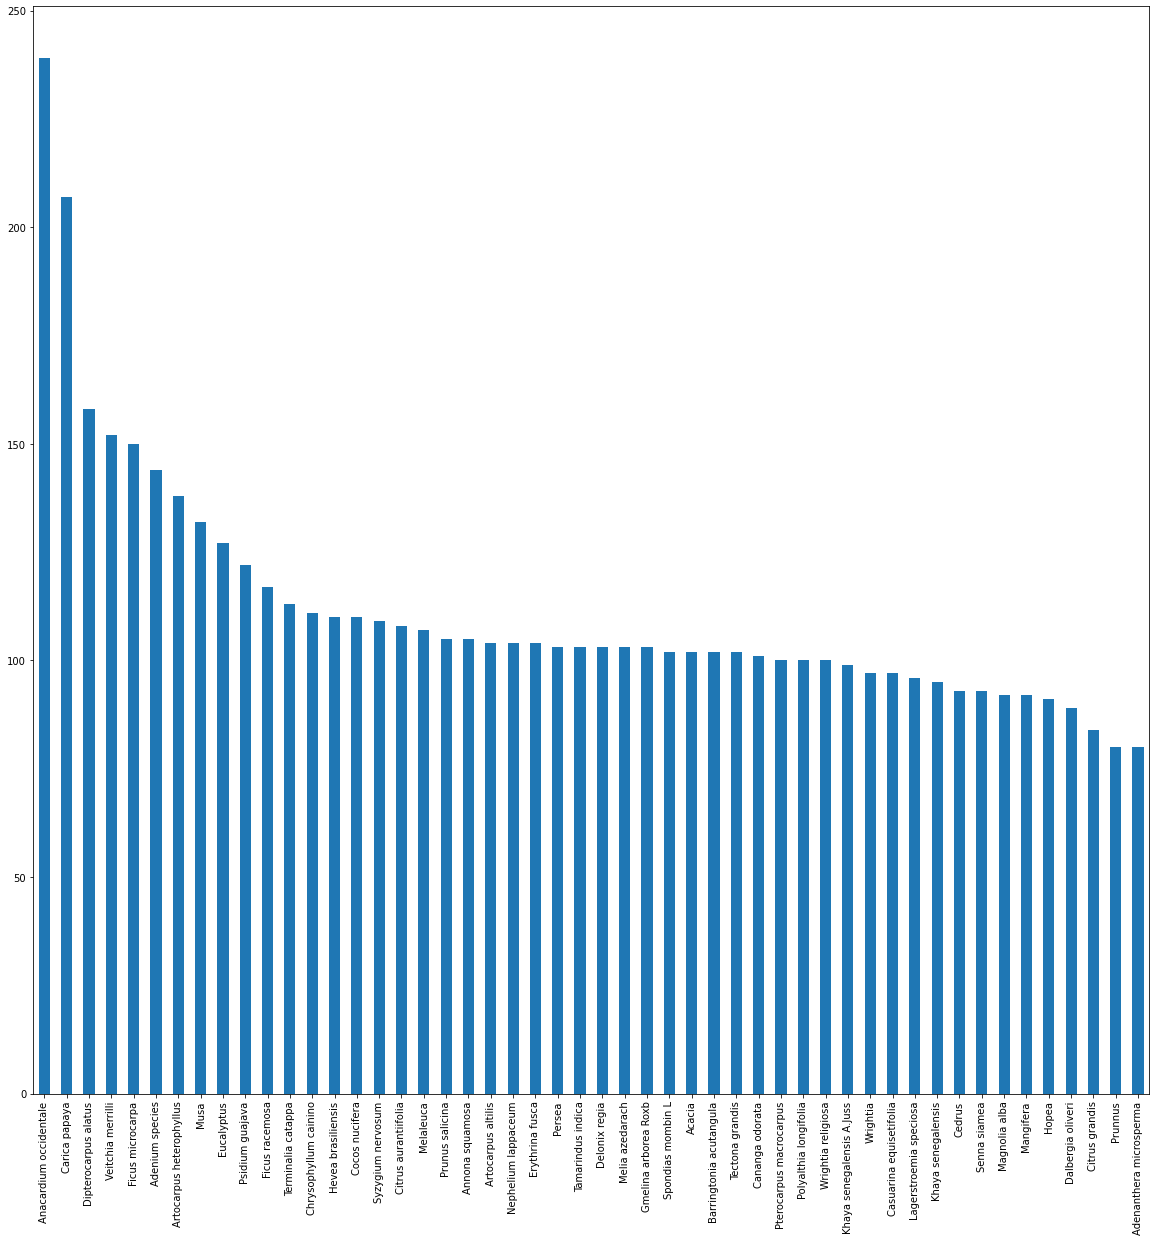

In [6]:
plt.figure(figsize=(20,20))
pd.Series(dir_to_img).sort_values(ascending=False).plot(kind='bar')

So we can see that there are more `Anacardium occidentale` than `Adenanthera microsperma` so this might lead to more bias. However, a technique to get rid of this other than deletion of images from the directories is unknown, however, since the data set that is being operated on is relatively small in the larger picture this disparity won't pose much of a threat. Besides taking away samples from the data would just damage our goal.

In [7]:
dir_to_shape = {}
for pic_dir in glob.glob("BarkVN-50/BarkVN-50_mendeley/*"):
    for image in glob.glob(f"{pic_dir}/*"):
        img_shape = np.asarray(Image.open(image).convert("L")).shape
        dir_to_shape.setdefault(pic_dir.split("/")[-1], []).append(img_shape)

In the cell above we collected all the

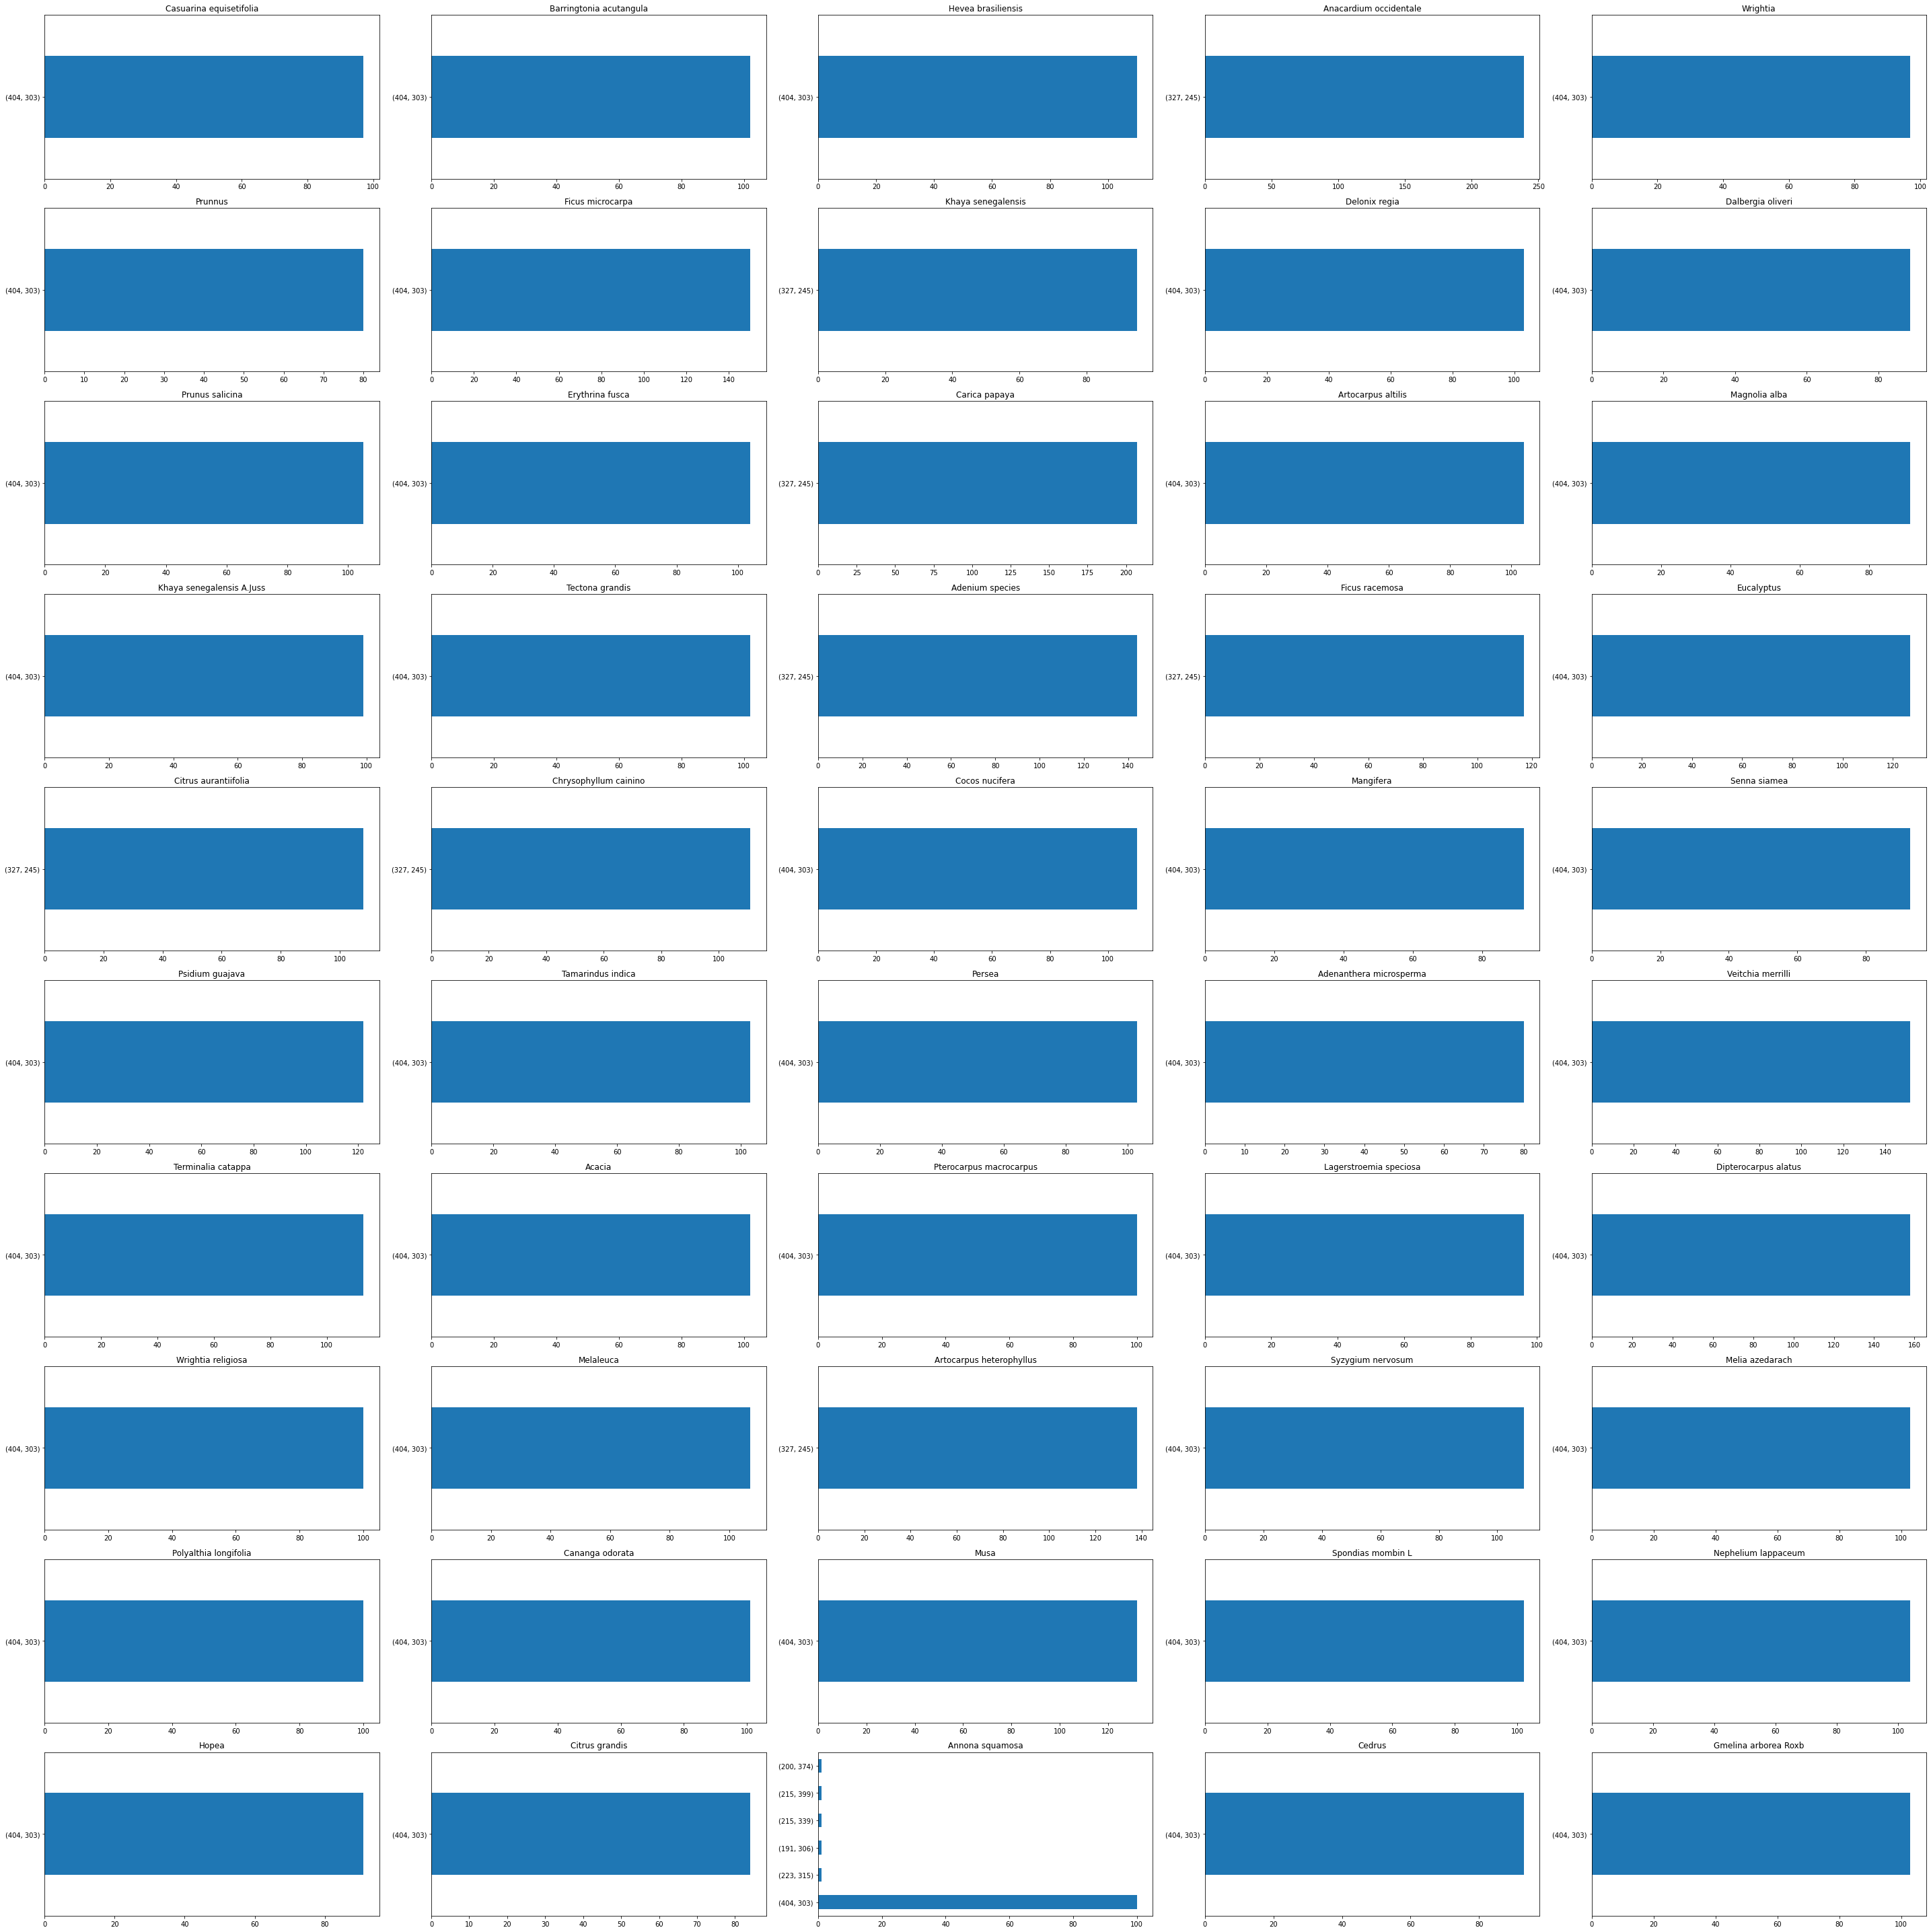

In [8]:
fig, axes = plt.subplots(10, 5, figsize=(40,40))
for i, dir_name in enumerate(dir_to_shape):
    plt.subplot(10, 5, i+1)
    plt.title(f'{dir_name}')
    pd.Series(dir_to_shape[f'{dir_name}']).value_counts().plot(kind='barh')
    
plt.tight_layout()
plt.show()

In [9]:
pd.Series(dir_to_shape[f'{dir_name}'])

0      (404, 303)
1      (404, 303)
2      (404, 303)
3      (404, 303)
4      (404, 303)
          ...    
98     (404, 303)
99     (404, 303)
100    (404, 303)
101    (404, 303)
102    (404, 303)
Length: 103, dtype: object

let's check the distribution of image sizes across all of the classes, this will help us better see if we need to scale all the images to one common size, and perhaps it will reveal several other aspects about our data. We will definitely need to standardize all of the images to a singular dimension.

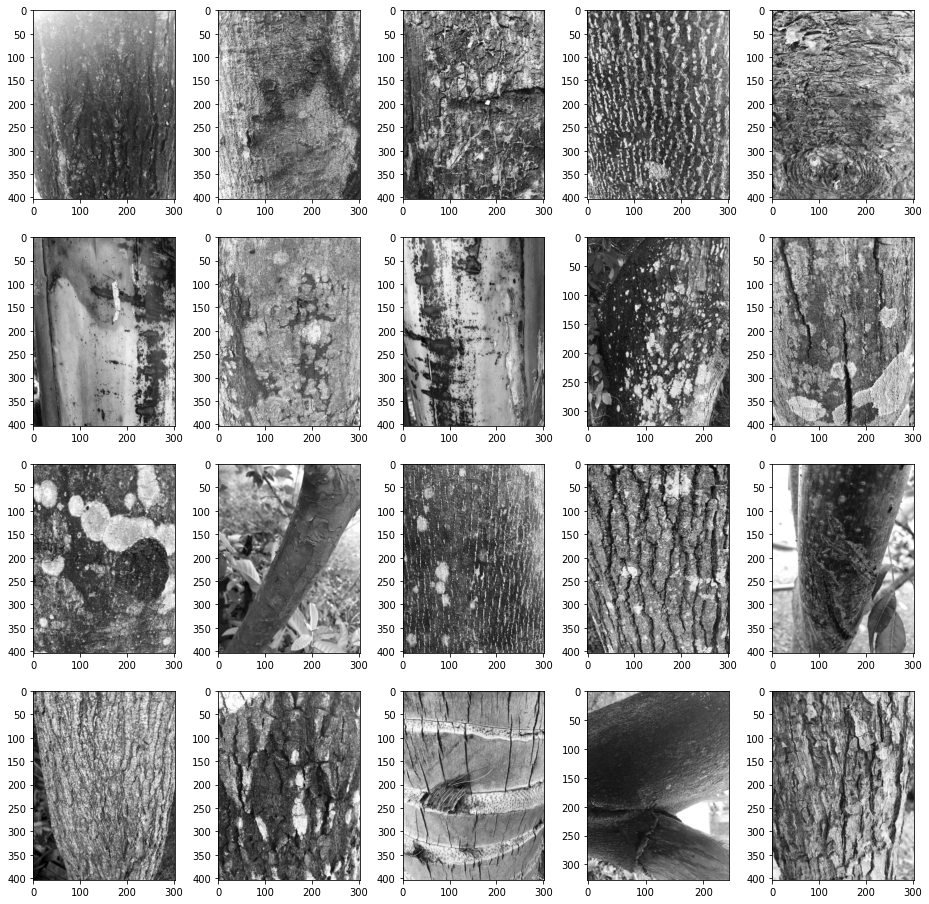

In [10]:
bulk_image_viewer(20)

let's set the desired dimensions we desire to work with in our models.

In [11]:
height = 224 
width = 224

In [102]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'BarkVN-50/BarkVN-50_mendeley',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(height, width),
  batch_size=32)

Found 5578 files belonging to 50 classes.
Using 4463 files for training.


In [103]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'BarkVN-50/BarkVN-50_mendeley',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(height, width),
  batch_size=32)


Found 5578 files belonging to 50 classes.
Using 1115 files for validation.


Let's look at some of the data without the grey scale and let's add some labels to it so we can see more clearly what is being worked with on here, and so that we can familiarize ourselves a little more with the classes and know them more by name.

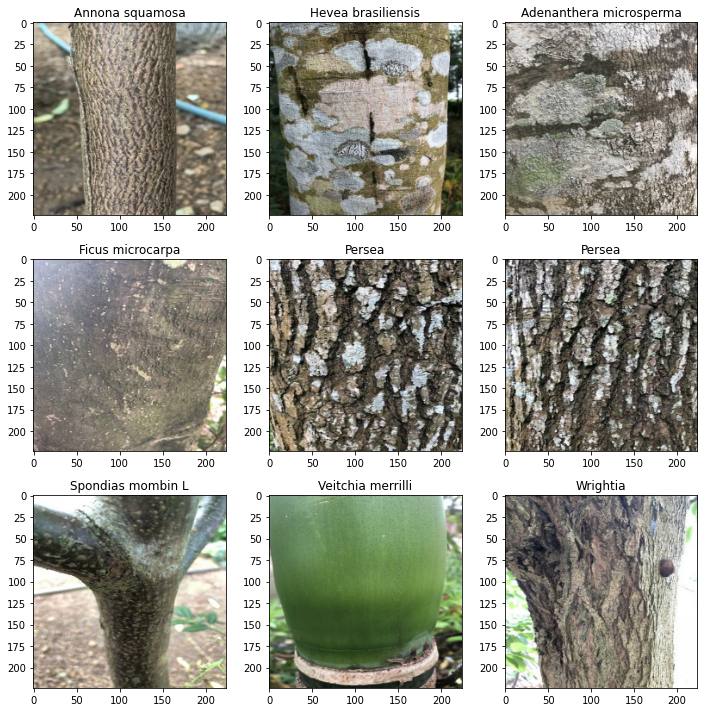

In [104]:
# Let's take a look at the data that we have 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for index in range(9):
    ax = plt.subplot(3, 3, index + 1)
    plt.imshow(images[index].numpy().astype("uint16"))
    plt.title(train_ds.class_names[labels[index]])
plt.tight_layout()
plt.show()

# First Model <a id='model1'></a>

We can now proceed to building our first neural network this one will be completely built from teh ground up by us, hence it will probably the most time costly to make, however, **the hypothesis is that the models that will be larger and will take longer to train will be better at achieving our end goal first mentioned in the beginning of the notebook**.

In [105]:
num_classes = len(train_ds.class_names)

# Let's try this 
model = Sequential([
  experimental.preprocessing.Rescaling(1./255, input_shape=(height, width, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.25),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.25),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.25),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='sigmoid')
])

In [106]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [107]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 32)        0

We can see we have relatively a lot of training parameters so let's see how our own constructed model performs based off of what we chose to implement within it.

In [108]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=2, 
)

Epoch 1/2
140/140 [==============================] - 182s 1s/step - loss: 3.7777 - accuracy: 0.0428 - val_loss: 3.6001 - val_accuracy: 0.0430
Epoch 2/2
140/140 [==============================] - 191s 1s/step - loss: 3.5350 - accuracy: 0.0450 - val_loss: 3.5289 - val_accuracy: 0.0430


In [109]:
print(f"score on train set was: {history.history['accuracy'][-1]}")

print(f"score on validation set was: {history.history['val_accuracy'][-1]}")

score on train set was: 0.04503697156906128
score on validation set was: 0.04304932802915573


So right now we can see that we have a lot of overfitting going on because we can see the model doesn't generalize well to the validation set, we need to fix this by perhaps reconsidering our model. Not only do we need to reconsider our model but our number of epochs also has to expand.

# Second Model <a id='model2'></a>

In [20]:
# Import the pretrained VGG16 network, do not include the top layers
pretrained = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(height,width,3))

Let's stop the model we loaded in from training it's weight so that we don't corrupt the natural already pre optimized behavior of the model.

In [21]:
# ensuring that VGG16 layers are not retrained i.e. weights remain constant
for layer in pretrained.layers:
    layer.trainable=False

Let's take prepare the data generator so tat we have more robust data to work with thus making our model less fragile when it comes to making predictions. Since our model will be exposed to more acute variance in the photos due to this data generator.

In [22]:
# Instantiating the training/validation ImageDataGenerator()
datagen_train = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                   fill_mode='reflect',
                                   validation_split=0.1)

Let's split our data into a training set and a validation set so later we can derive validation scores and training scores, we should standardize the input of the two sets so that all the images are the same size and the mode is rgb since we don't have any imbalanced behavior that yields bad results.

In [23]:
# Generator for the training data, shuffle set to True 
train_generator = datagen_train.flow_from_directory('BarkVN-50/BarkVN-50_mendeley/',
                                                    target_size=(height, width),
                                                    color_mode="rgb",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    shuffle=True, subset='training')

# Generator for validation data, shuffle set to 'False' 
validation_generator = datagen_train.flow_from_directory('BarkVN-50/BarkVN-50_mendeley/',
                                                    target_size=(height, width),
                                                    color_mode="rgb",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    shuffle=False, subset='validation')

Found 5039 images belonging to 50 classes.
Found 539 images belonging to 50 classes.


In [24]:
# Saving the number of stepsizes for the training, validation and test sets 
train_stepsize = train_generator.samples//train_generator.batch_size    # note integer division operator

valid_stepsize = validation_generator.samples//validation_generator.batch_size 

# Sanity check 
print(f'Training step size = {train_stepsize} \nValidation step size = {valid_stepsize}')

Training step size = 251 
Validation step size = 26


Now let's construct the model using our main building blocks which consist of `Dense`, `Dropout` layers that are the final layers as well as our pre-trained`VGG16` model.

In [25]:
# Instantiate the NN model 
bark_model = Sequential()

# Add the pretrained layers 
bark_model.add(pretrained)

# Add fully-connected dense layers -- plus a dropout layer to help prevent overfitting
bark_model.add(Dense(256, activation='relu'))
bark_model.add(Dropout(0.5))
bark_model.add(Dense(512, activation='relu'))

# Adding our activation 
bark_model.add(Dense(num_classes, activation='softmax'))

Now that we constructed the model itself we can go onto the compilation of the model and at this stage the model is being glued together and getting assembled in order for it to be trained.

In [26]:
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
bark_model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

# Summary 
bark_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 50)                25650     
Total params: 15,003,250
Trainable params: 288,562
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = bark_model.fit(train_generator,
                        steps_per_epoch=train_stepsize,
                        epochs=10,
                        validation_data=validation_generator,
                        validation_steps=valid_stepsize)

Now let's view the history of the training model to see the accuracy we achieved, and let's compare it to the goal that was set for our ideal model.

In [ ]:
print(f"score on train set was: {history.history['acc'][-1]}")

print(f"score on validation set was: {history.history['val_acc'][-1]}")

Now let's examine how the model performed graphically.

In [ ]:
plt.subplots(1,2,figsize =(10,4))
# Let's plot the loss over the 10 epochs
plt.subplot(1,2,1)
plt.plot(history.history['loss'], marker='o', label='training loss')
plt.plot(history.history['val_loss'], marker='o', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Let's see the loss over 
plt.subplot(1,2,2)
plt.plot(history.history['acc'], marker='o', label='training accuracy')
plt.plot(history.history['val_acc'], marker='o', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

So overall we can see that the model definitely progressed, however, it left a lot to be desired, we can say this model does not meet the goals of 70%+ accuracy for both validation and training and less than 5% gap between teh two accuracies, also noticed that the amount of epochs took long to run, so increasing the amount of epochs would not be a wise decision for next time around.

So what we can see is that there is a a nice fit on our training set and data, however, our goal was to have a 70%+ training set accuracy and a gap of 5% or less between the train and test/lidation set. So let's try `ResNet50V2`.

# Third Model <a id='model3'></a>

In [27]:
pretrained_resnet = ResNet50V2(weights='imagenet', include_top=False, pooling='max', input_shape=(height,width,3))

Now we can either change a lot of parameters from the previous model or keep the the same, at this point keeping them the same is a wiser choice. The reason this choice is being made is because the merit of the individual pre-trained network is being tested so we can find out which one is better for this use case.

In [28]:
pretrained_resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Once again let's turn off the weights for the pre-trained layers of our network.

In [29]:
for layer in pretrained_resnet.layers:
    layer.trainable = False

Let's construct this model, much like the last model we can keep it nice and simple and not change much if anything because we are merely trying to see which pre trained model is better between `VGG16` and `ResNet50V2`.

In [30]:
# Instantiate the NN model 
bark_model_v2 = Sequential()

# Add the pretrained layers 
bark_model_v2.add(pretrained_resnet)

# Add fully-connected dense layers -- plus a dropout layer to help prevent overfitting
bark_model_v2.add(Dense(256, activation='relu'))
bark_model_v2.add(Dropout(0.5))
bark_model_v2.add(Dense(512, activation='relu'))

# Adding our activation 
bark_model_v2.add(Dense(num_classes, activation='softmax'))

let's compile it again like we did with the previous model.

In [31]:
# Compiling the CNN model 
bark_model_v2.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

# Summary 
bark_model_v2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 50)                25650     
Total params: 24,246,578
Trainable params: 681,778
Non-trainable params: 23,564,800
_________________________________________________________________


In [32]:
history_v2 = bark_model_v2.fit(train_generator,
                        steps_per_epoch=train_stepsize,
                        epochs=10,
                        validation_data=validation_generator,
                        validation_steps=valid_stepsize)

bark_model_v2.save('models')

Epoch 1/10
251/251 [==============================] - 870s 3s/step - loss: 4.1579 - acc: 0.1241 - val_loss: 2.8541 - val_acc: 0.3173
Epoch 2/10
251/251 [==============================] - 922s 4s/step - loss: 2.6805 - acc: 0.3278 - val_loss: 2.0447 - val_acc: 0.4500
Epoch 3/10
251/251 [==============================] - 878s 3s/step - loss: 2.0571 - acc: 0.4531 - val_loss: 1.6092 - val_acc: 0.5673
Epoch 4/10
251/251 [==============================] - 749s 3s/step - loss: 1.7014 - acc: 0.5394 - val_loss: 1.3521 - val_acc: 0.6365
Epoch 5/10
251/251 [==============================] - 916s 4s/step - loss: 1.4664 - acc: 0.5890 - val_loss: 1.2622 - val_acc: 0.6462
Epoch 6/10
251/251 [==============================] - 907s 4s/step - loss: 1.3352 - acc: 0.6188 - val_loss: 1.1756 - val_acc: 0.6673
Epoch 7/10
251/251 [==============================] - 861s 3s/step - loss: 1.1817 - acc: 0.6545 - val_loss: 1.0624 - val_acc: 0.6962
Epoch 8/10
251/251 [==============================] - 613s 2s/step - 

So now we get a result that we desired over 10, epochs, now we can without a doubt say that the `ResNet50V2` is superior to the `VGG16` model. We can conclude that because the training and validation accuracy is higher on `ResNet50V2`, in addition we can analyse how the accuracy fared on each eposh that we ran the datta for, and let's compare that to the loss of the model. Using these metrics let's see whta can be concluded.

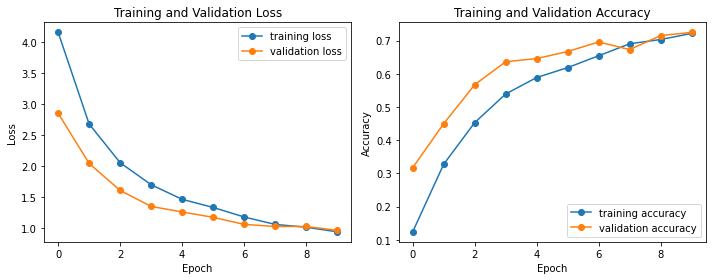

In [36]:
plt.subplots(1,2,figsize =(10,4))

# Let's plot the loss over the 10 epochs
plt.subplot(1,2,1)
plt.plot(history_v2.history['loss'], marker='o', label='training loss')
plt.plot(history_v2.history['val_loss'], marker='o', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Let's see the loss over 
plt.subplot(1,2,2)
plt.plot(history_v2.history['acc'], marker='o', label='training accuracy')
plt.plot(history_v2.history['val_acc'], marker='o', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

So what we can see is that the model proved to be very accurate over the 10 epochs and the loss was maximized over that same cycle, however, these two metrics aren't enough for us to see how well this model performs in the real world, so let us generate the confusion matrix with which we can than provide further insight on the model.

In [21]:
# Apply the same rescaling factor as our other generators
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('BarkVN-50/BarkVN-50_mendeley/',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=100,
                                                  class_mode='categorical')


X_test, y_test = test_generator.next()

Found 5578 images belonging to 50 classes.


So what we just did was create a test set to see how well our data performs on it, looking at this it might be a better idea to use outside data so we can see how the model deals with exogenous data, endogenous test data is bound to perform well.

In [22]:
# Evaluate the model's performance on the test data
score = bark_model_v2.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'bark_model_v2' is not defined

Let's load in our model to make sure it is the same model that we saved, using this we now don't have to re-run our notebook in case it crashes in order to retrain the model, so let's get it from our `models` directory.

In [23]:
# Let's retrieve the model that we saved
main_model = keras.models.load_model('models')

In [24]:
# Let's score the model to see if it is as accurate as bark_model_v2
score_v2 = main_model.evaluate(X_test, y_test, verbose=1)
print('test acc is', score_v2[1])

4/4 [==============================] - 6s 1s/step - loss: 0.3166 - acc: 0.9500
test acc is 0.949999988079071


So we can see that as expected wee got a high accuracy test set, so while we are at it let's try to get the confusion matrix for our model to get further to get insight into measuring metrics of the model. This confusion matrix will be very telling about the mistakes our data is making.

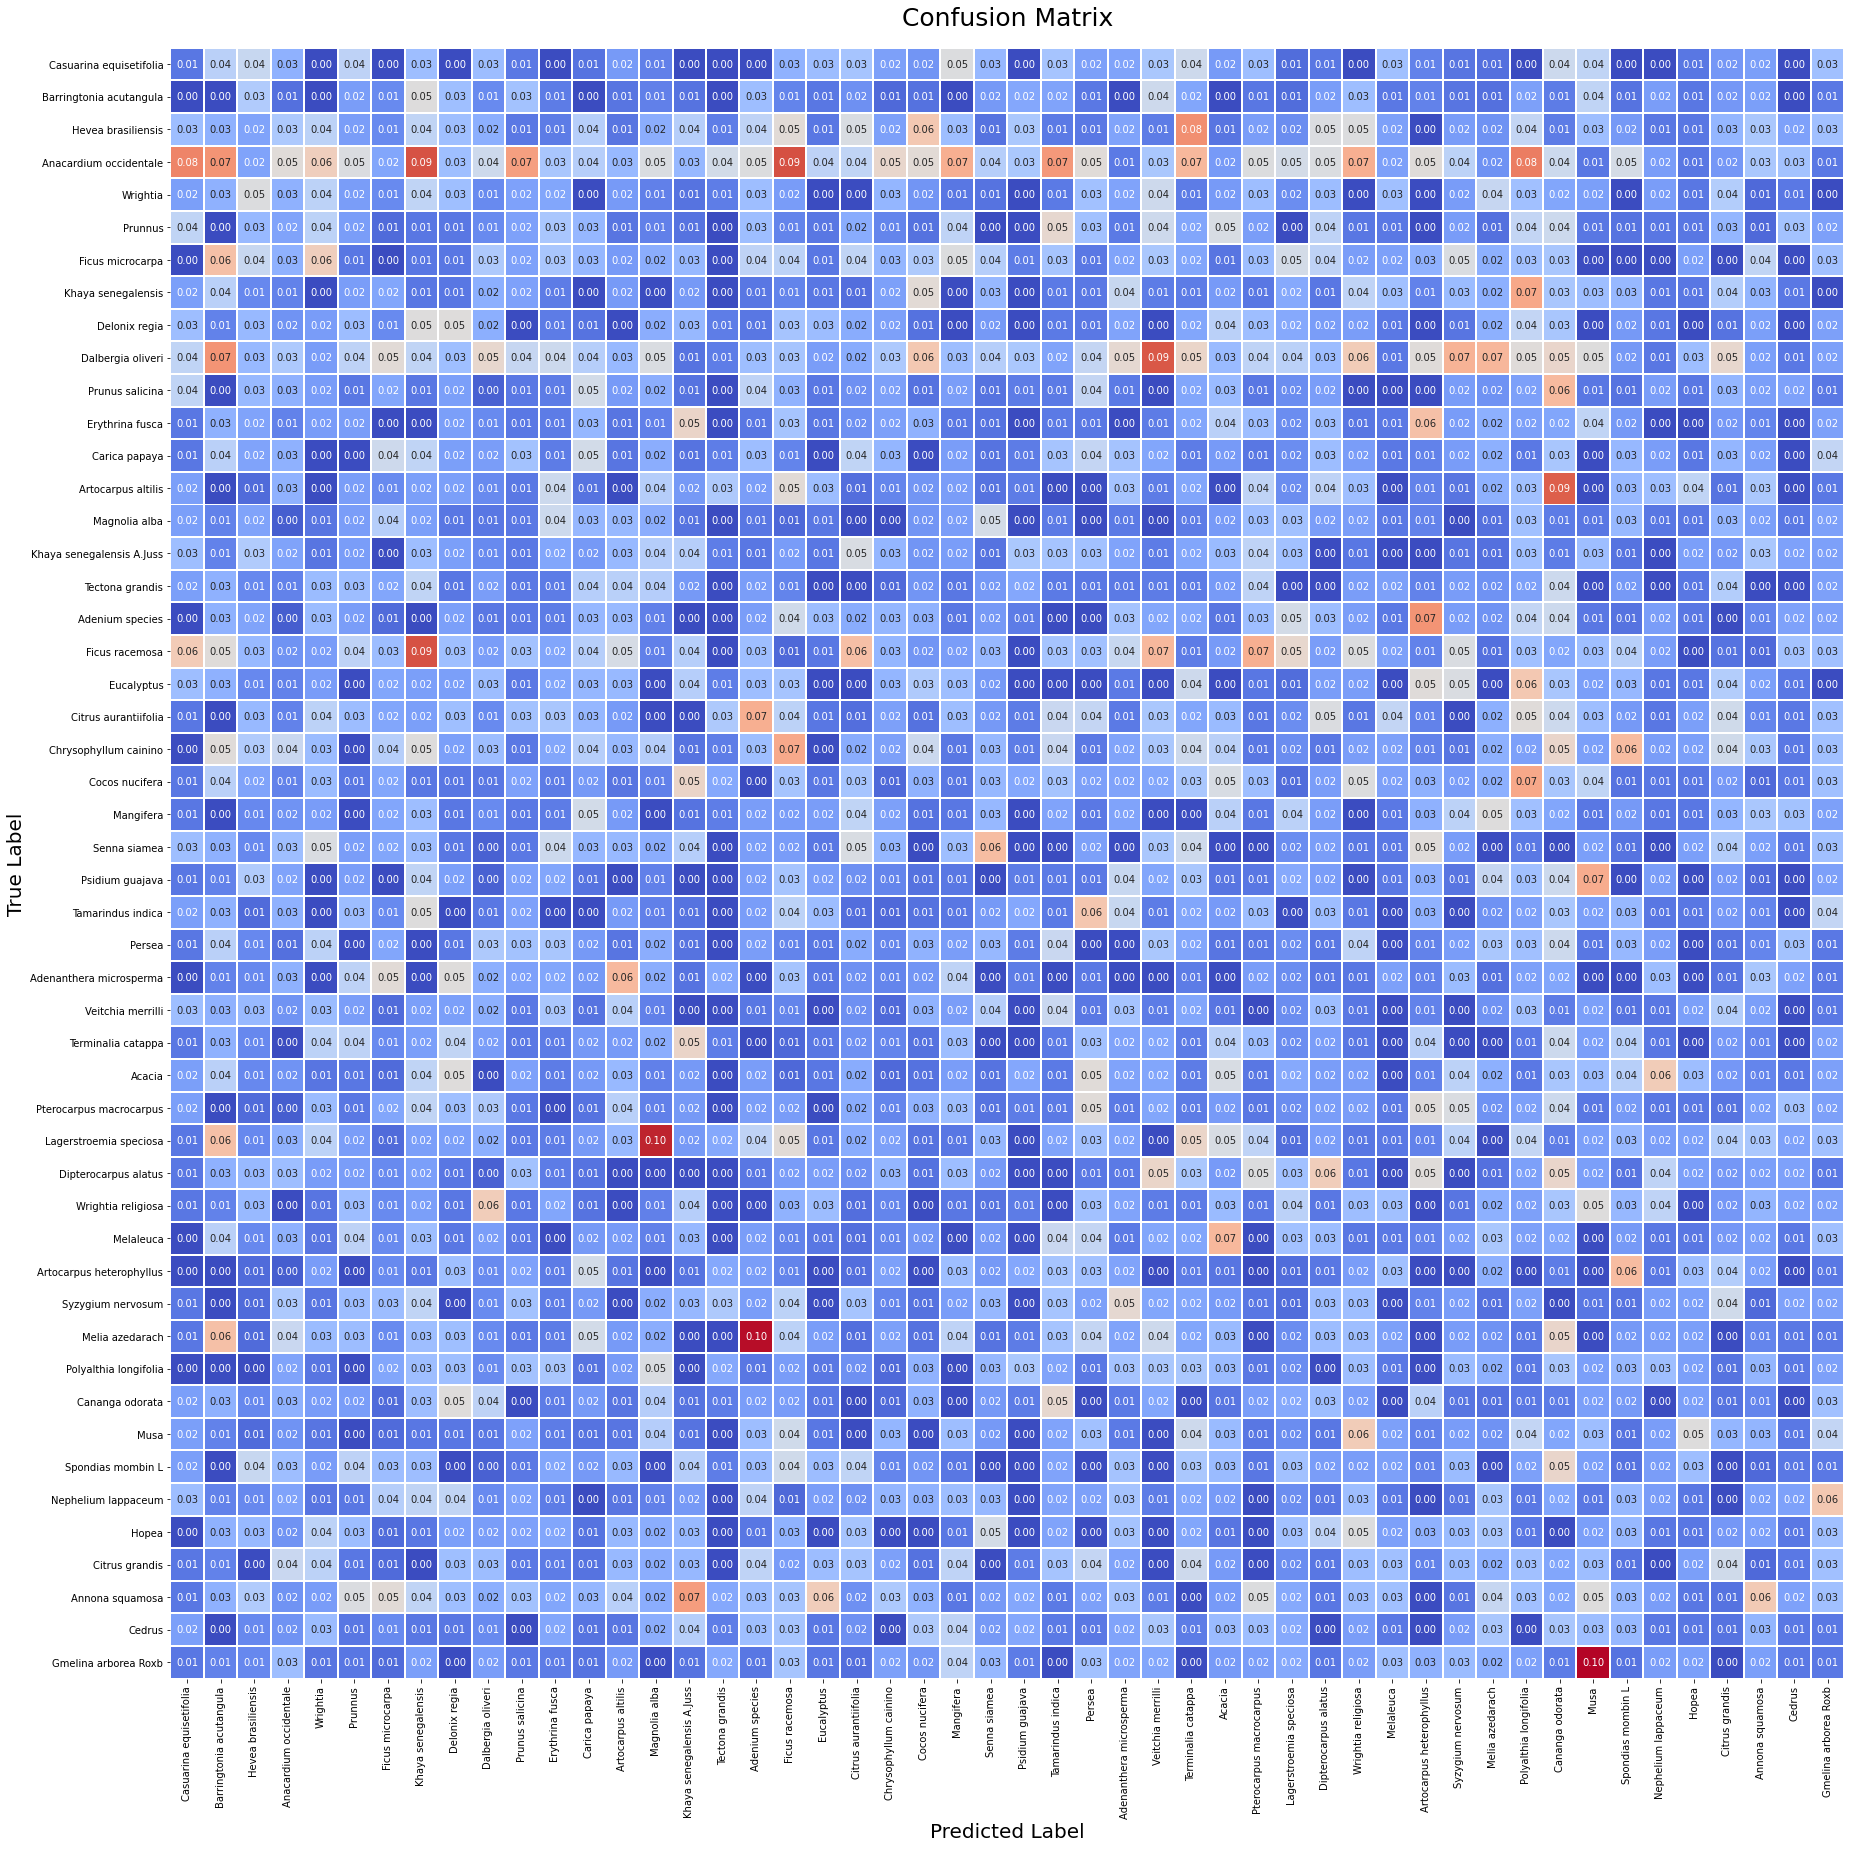

In [25]:
# Calculate the predictions
predict_probas = main_model.predict(test_generator)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

# Convert our test labels from one-hot encoding to label encoding
y_test_labels = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(test_generator.labels, y_predict)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.subplots(figsize=(30,30))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            xticklabels=list(dir_to_shape.keys()),
            yticklabels=list(dir_to_shape.keys()),
            cmap="coolwarm",
            linewidths=1,
            fmt='.2f'
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

Everytime the cell above is ran we get a little different results however the folowing is the general trend I noticed. So we can see that there is a a clear confusion between a lot of these classes however, the confusion is minimal for the most part the confusion is around 3%. However, the most classes that get the most confused with other classes is the `Dalbergia oliveri` which often gets confused for `Khaya senegalensis`, 10% percent of the time actually. Not to mention the tree species that gets the most confused for another tree species is `'Anacardium occidentale` it gets confused 14% of the time for the `Veitchia merrilli` species.

### Testing Out The Model
Let's see what images are classified by simply grabbing random images and see how they are classified and see if they are classified correctly.

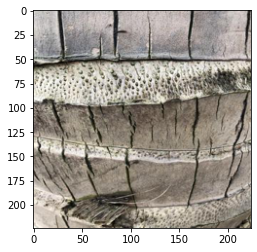

In [27]:
from keras.preprocessing import image

# Load in the path of nay given image
im_path = 'BarkVN-50/BarkVN-50_mendeley/Cocos nucifera/IMG_3522.JPG'

# Load in the test image
test_image = np.expand_dims(image.img_to_array(image.load_img(f'{im_path}')), axis=0)

# Let's now see what the image looks like
plt.imshow(Image.open(f'{im_path}').resize((width, height)))

In [28]:
# Let's call the predict method to see what kind of prediction we get
print(f'The model thinks this image belongs to class {list(dir_to_shape.keys())[np.argmax(np.round(main_model.predict(test_image), 4)*100)]}')

print(f'And it predict this with a {np.max(np.round(main_model.predict(test_image), 4)*100)} confidence')

The model thinks this image belongs to class Artocarpus heterophyllus
And it predict this with a 100.0 confidence


What if we used external imagery on our model? let's try using images from the web so that we can see what it classifies it as, *this can be made into a python script*. Let's demonstrate how this can be done.

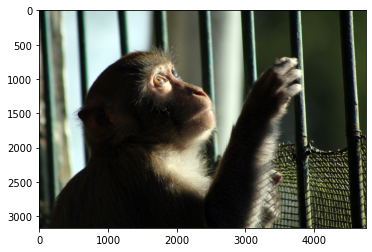

In [29]:
url = "https://baobab-poseannotation-appfile.s3.amazonaws.com/media/project_5/images/images01/01418849d54b3005.o.1.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
plt.show()

So what kind of tree bark type is a monkey?

In [30]:
# Let's load in teh monkey image 
test_image_2 = np.expand_dims(image.img_to_array(img), axis=0)

In [31]:
print(f'The model thinks this image belongs to class {list(dir_to_shape.keys())[np.argmax(np.round(main_model.predict(test_image_2), 4)*100)]}')

print(f'And it predict this with a {np.max(np.round(main_model.predict(test_image_2), 4)*100)} confidence')

The model thinks this image belongs to class Magnolia alba
And it predict this with a 100.0 confidence


# Summary
What we have learned is that the `ResNet50V2` along with some other custom parameters added is the best model that we can conjure in order to classify the 50 types of tree bark, and we indeed achieved our desired goal so that, thus this capstone can be considered a success. 